<a href="https://colab.research.google.com/github/araujofc/PosIFES/blob/main/FabricioCAraujo_aula6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from sklearn import datasets
dataset = datasets.load_wine()

X, y = dataset.data, dataset.target

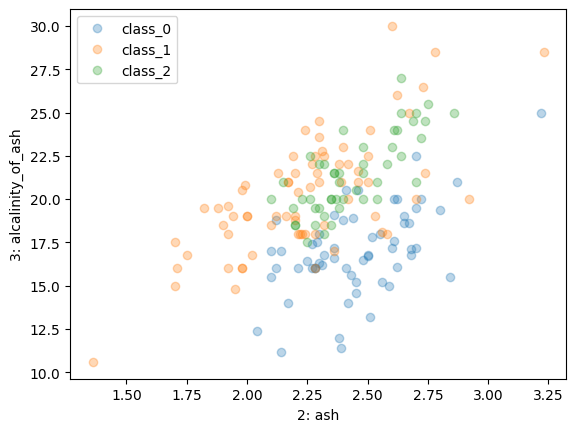

In [8]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

# visualizando a distribuição das amostras do conjunto de dados Wine em relação a duas características específicas.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.38888889, 0.38888889, 0.38888889, 0.4       , 0.42857143]),
 0.3990476190476191)

In [10]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.398876404494382

In [11]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.702247191011236

In [12]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.36111111, 0.47222222, 0.5       , 0.4       , 0.28571429]),
 0.4038095238095238)

In [13]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.6583133442747129

In [14]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.6434985114760395, 0.6419753086419754, 0.647189349112426)

In [15]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(2.295, 0.6139307817100282)

In [16]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.43761750381193476, 12, 979.0)

In [17]:
# classificador de árvore de decisão muito básico, usando a classe Arvore.

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [18]:
# Alterar a heurística de uma Árvore de decisão para atributos contínuos

# A partir do código implementado em aula, altere a função melhorValor, de forma que esta busque todos os valores de cada característica que seja a média entre duas instâncias consecutivas, em relação à ordem dos valores daquela característica.

# postre/aula6b_Árvores_de_decisão_atributos_contínuos.ipynb at main · fboldt/postre (github.com)

# Isto é, na nova heurística, os valores verificados serão calculados da seguinte forma. Para cada característica, ordene as instâncias pelo valor e teste o valor médio entre a primeira e a segunda instância. Depois teste o valor médio entre a segunda e a terceira instância, e assim por diante. A nova função deve retornar o melhor valor encontrado para aquela característica.

# Compare a nova heurística com a antiga usando um dataset diferente do usado na aula.

# Qual heurística apresenta melhor desempenho de classificação no novo dataset?

# Qual heurística treina seus modelos mais rapidamente?

# Coloque o link de um jupyter notebook no seu GitHub para ser avaliado.

SyntaxError: ignored

In [19]:
# esta função melhorValorNew procura iterativamente o valor de x que minimiza a impureza total, onde a impureza é calculada com base
# em uma função chamada impurezaValor. O resultado é o valor e a menor impureza associada a esse valor. O código final imprime esse resultado.

def melhorValorNew(x, y):
    result = None
    menorImpurezanew = float('inf')
    x_sorted_idx = np.argsort(x)
    sorted_x = x[x_sorted_idx]
    sorted_y = y[x_sorted_idx]

    for i in range(len(x) - 1):
        valor = (sorted_x[i] + sorted_x[i + 1]) / 2
        impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)

        if impTotal < menorImpurezanew:
            menorImpurezanew = impTotal
            result = valor

            if impMaiores == 0 or impMenores == 0:
                break
    return result, menorImpurezanew

resultado_melhor_valor = melhorValorNew(X[:, 2], y)
print("Resultado da função melhorValor (valor, impureza):", resultado_melhor_valor)


Resultado da função melhorValor (valor, impureza): (1.53, 0.6552402716942805)


In [20]:
def melhorCaracteristicaNew(X, y):
    newimpurezas = []
    newvalores = []

    # Itera sobre cada característica no conjunto de dados
    for caracteristica in range(X.shape[1]):
        # Calcula o melhor valor e a impureza para a característica atual
        valor, imp = melhorValor(X[:, caracteristica], y)

        # Armazena o valor do ponto de divisão e a impureza para a característica atual
        newimpurezas.append(imp)
        newvalores.append(valor)

    # Converte as listas para arrays numpy para análise mais fácil
    newimpurezas = np.array(newimpurezas)
    caracteristica = np.argmin(newimpurezas)  # Encontra o índice da característica com a menor impureza
    return newimpurezas[caracteristica], caracteristica, newvalores[caracteristica]

resultado_melhor_caracteristica = melhorCaracteristicaNew(X, y)
print("Resultado da função melhorCaracteristica (impureza, característica, valor):", resultado_melhor_caracteristica)


Resultado da função melhorCaracteristica (impureza, característica, valor): (0.43761750381193476, 12, 979.0)


In [21]:
class ArvoreNew(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        impureza, caracteristica, valor = melhorCaracteristicaNew(X, y)
        self.impureza = impureza
        self.caracteristica = caracteristica
        self.valor = valor

        maiores = X[:, caracteristica] > valor
        if sum(maiores) > 0 and sum(~maiores) > 0:
            self.maiores = ArvoreNew()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = ArvoreNew()
            self.menores.fit(X[~maiores, :], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
        return self

    def predict(self, X, y=None):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

modeloNew = ArvoreNew()
modeloNew.fit(X, y)
ypred = modeloNew.predict(X)
acuracia_modelo = sum(y == ypred) / len(y)

scores = cross_validate(ArvoreNew(), X, y)
test_scores, media_test_scores = scores['test_score'], np.mean(scores['test_score'])


In [22]:

#  implementação da árvore de decisão e de um classificador de linha de base para comparação. Ele é usado para avaliar o desempenho relativo dos dois modelos em termos de média da validação
#  cruzada e tempo de execução.


class ArvoreNew(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        impureza, caracteristica, valor = melhorCaracteristicaNew(X, y)
        self.impureza = impureza
        self.caracteristica = caracteristica
        self.valor = valor

        maiores = X[:, caracteristica] > valor
        if sum(maiores) > 0 and sum(~maiores) > 0:
            self.maiores = ArvoreNew()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = ArvoreNew()
            self.menores.fit(X[~maiores, :], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
        return self

    def predict(self, X, y=None):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

modeloNew = ArvoreNew()
modeloNew.fit(X, y)
ypred = modeloNew.predict(X)
sum(y == ypred) / len(y)

scores = cross_validate(ArvoreNew(), X, y)
scores['test_score'], np.mean(scores['test_score'])

from sklearn.model_selection import cross_val_score
import time

modelo_antigo = ZeroR()
inicio_antigo = time.time()
scores_antigo = cross_val_score(modelo_antigo, X, y)
tempo_antigo = time.time() - inicio_antigo
media_antigo = np.mean(scores_antigo)

modelo_novo = ArvoreNew()
inicio_novo = time.time()
scores_novo = cross_val_score(modelo_novo, X, y)
tempo_novo = time.time() - inicio_novo
media_novo = np.mean(scores_novo)

print("Resultados do Modelo Antigo:")
print(f"Média da validação cruzada: {media_antigo:.2f}")
print(f"Tempo de execução: {tempo_antigo:.4f} segundos\n")

print("Resultados do Modelo Novo:")
print(f"Média da validação cruzada: {media_novo:.2f}")
print(f"Tempo de execução: {tempo_novo:.4f} segundos")


Resultados do Modelo Antigo:
Média da validação cruzada: 0.40
Tempo de execução: 0.0056 segundos

Resultados do Modelo Novo:
Média da validação cruzada: 0.89
Tempo de execução: 1.3305 segundos


In [ ]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.77777778, 0.88888889, 0.83333333, 1.        , 0.97142857]),
 0.8942857142857144)

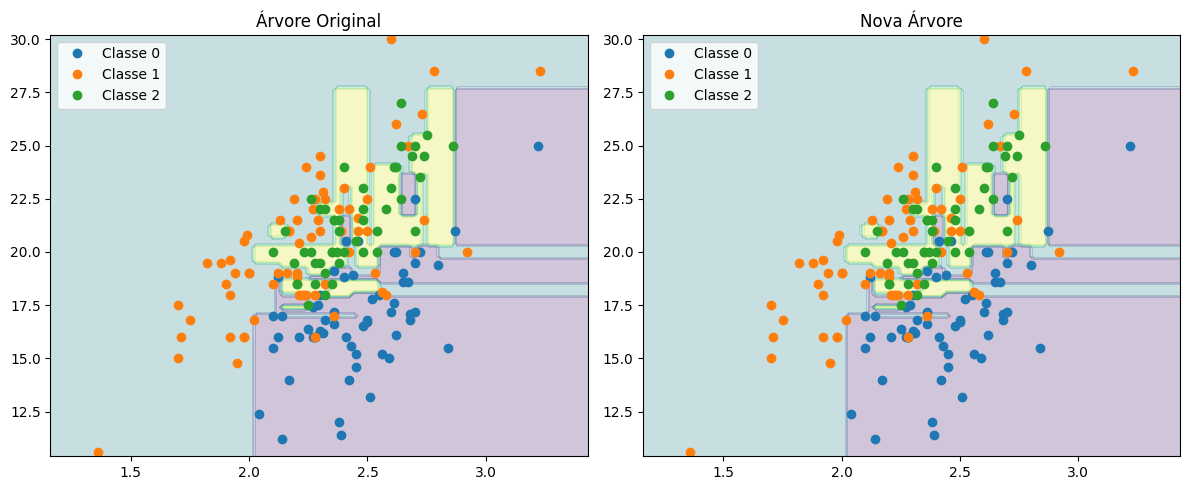

In [ ]:
def plotDecisao(modelo1, modelo2, X, y):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for ax, modelo, titulo in zip(axs, [modelo1, modelo2], ['Árvore Original', 'Nova Árvore']):
        modelo.fit(X, y)
        x0s = np.linspace(np.min(X[:, 0]) - 0.2, np.max(X[:, 0]) + 0.2, 100)
        x1s = np.linspace(np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2, 100)
        x0, x1 = np.meshgrid(x0s, x1s)
        Xdec = np.c_[x0.ravel(), x1.ravel()]
        ypred = modelo.predict(Xdec)
        ax.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
        for k in set(y):
            ax.plot(X[:, 0][y == k], X[:, 1][y == k], 'o', label=f"Classe {k}")
        ax.set_title(titulo)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Utilização da função plotDecisao com os modelos Arvore e ArvoreNew
plotDecisao(Arvore(), ArvoreNew(), X[:, 2:4], y)


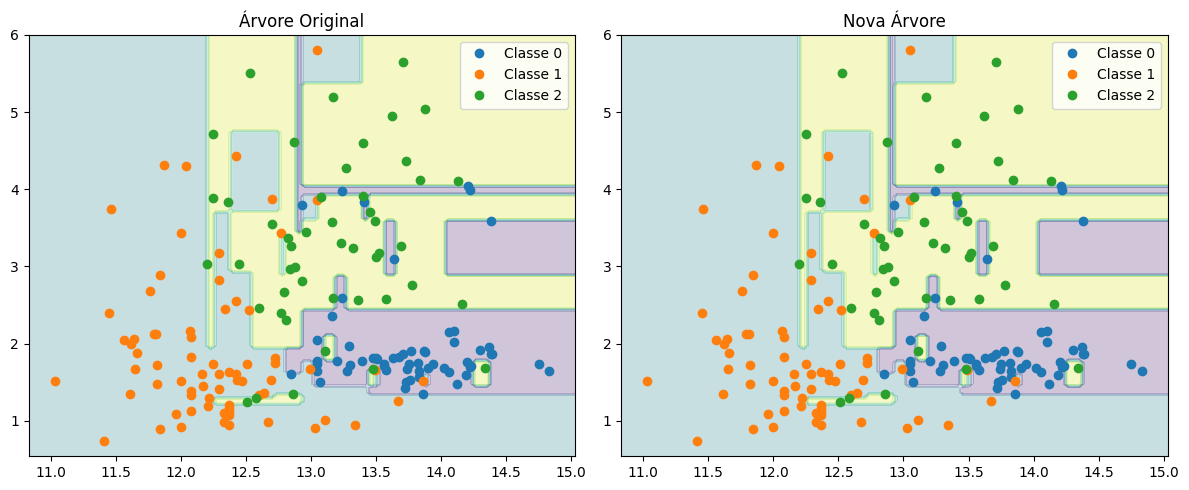

In [ ]:
plotDecisao(Arvore(), ArvoreNew(), X[:,:2], y)

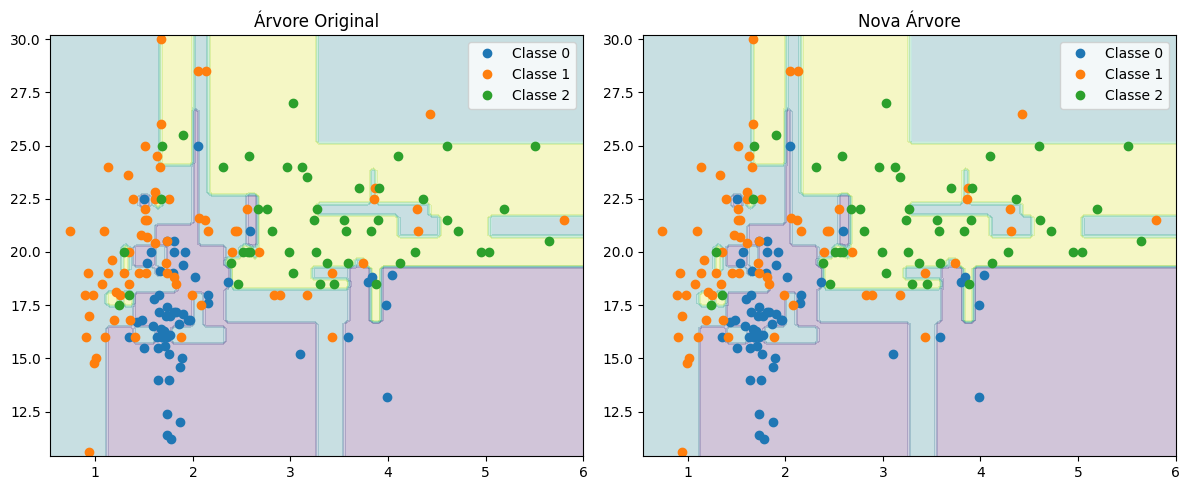

In [ ]:
#plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(Arvore(), ArvoreNew(),X[:,[1,3]], y)

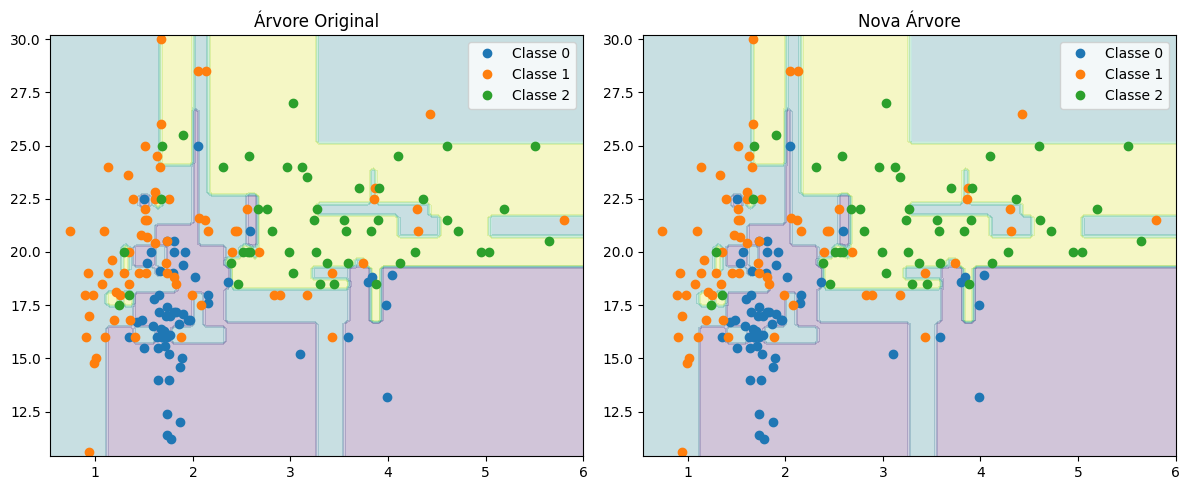

In [ ]:
#plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(Arvore(), ArvoreNew(),X[:,[1,3]], y)

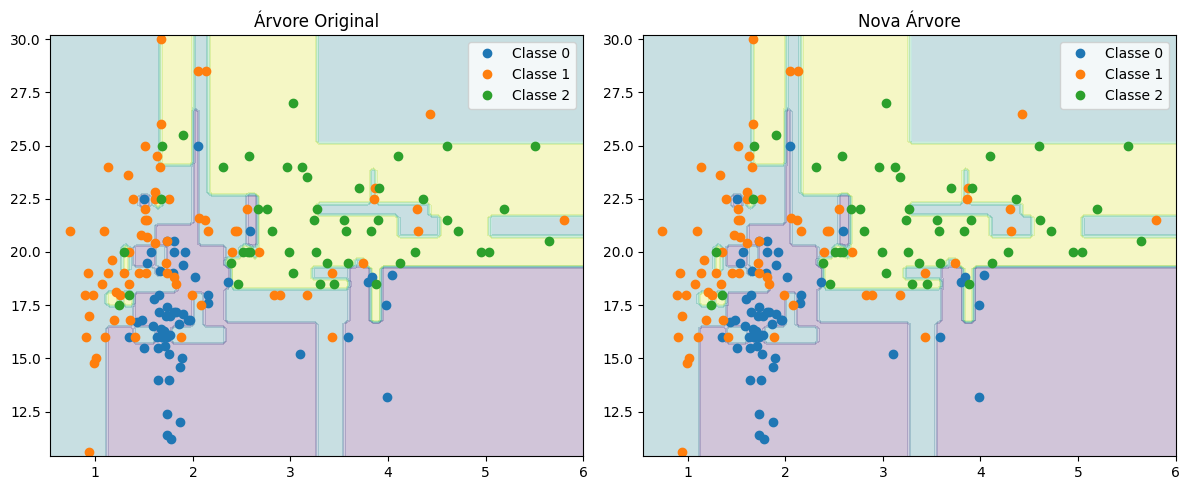

In [ ]:
#plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(Arvore(), ArvoreNew(),X[:,[1,3]], y)